In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from data import combine_with_reverb, create_bertified_dataset
from utils import read_data

In [14]:
combine_with_reverb()
create_bertified_dataset()

In [15]:
QUESTION_WORDS = ['what', 'which', 'where', 'when', 'why', 'who', 'how', 'whom']

In [32]:
def question_word_id(string):
    for item in string.strip().lower().split():
        if item in QUESTION_WORDS:
            return item
    return 'None'

In [33]:
train_df = pd.read_excel('train.xlsx'); valid_df = pd.read_excel('valid.xlsx'); test_df = pd.read_excel('test.xlsx')

In [34]:
train_df.head()

,Unnamed: 0,Unnamed: 0.1,Meaningful,Reverb_no,Sentecne,Confidence,Question,Answer,token_matrix,triple,normalized_triple,first_entity_ids,second_entity_ids,relation_ids
0,4364,4520,1,178500,Judge Baker retired in Jacksonville,0.90925,who retired in Jacksonville,Judge Baker,"[101, 2040, 3394, 1999, 13057, 102]","('Judge Baker', 'retired in', 'Jacksonville')","('judge baker', 'retire in', 'jacksonville')","[101, 3648, 6243, 102]","[101, 13057, 102]","[101, 3394, 1999, 102]"
1,4204,4356,1,171931,Jean Langlais was a French composer of modern ...,0.91363,who was a French composer of modern classical ...,Jean Langlais,"[101, 2040, 2001, 1037, 2413, 4543, 1997, 2715...","('Jean Langlais', 'was a French composer of', ...","('jean langlais', 'be a french composer of', '...","[101, 3744, 11374, 28704, 102]","[101, 2715, 4556, 2189, 102]","[101, 2001, 1037, 2413, 4543, 1997, 102]"
2,17565,18180,1,321285,Tanzania has a large number of traditional ins...,0.93349,what does Tanzania have,a large number of traditional instruments,"[101, 2054, 2515, 11959, 2031, 102]","('Tanzania', 'has a large number of', 'traditi...","('tanzania', 'have a large number of', 'tradit...","[101, 11959, 102]","[101, 3151, 5693, 102]","[101, 2038, 1037, 2312, 2193, 1997, 102]"
3,6826,7056,1,279685,Robert died in 2003,0.93349,who died in 2003,Robert,"[101, 2040, 2351, 1999, 2494, 102]","('Robert', 'died in', '2003')","('robert', 'die in', '2003')","[101, 2728, 102]","[101, 2494, 102]","[101, 2351, 1999, 102]"
4,18580,19231,1,362829,Tumbes is a province in Peru,0.93076,where is Tumbes,in Peru,"[101, 2073, 2003, 10722, 18552, 2015, 102]","('Tumbes', 'is a province in', 'Peru')","('tumbes', 'be a province in', 'peru')","[101, 10722, 18552, 2015, 102]","[101, 7304, 102]","[101, 2003, 1037, 2874, 1999, 102]"


In [35]:
def get_question_words_distribution(dataframe):
    dataframe['question words'] = dataframe['Question'].astype(str).apply(question_word_id)
    print(dataframe.groupby(['question words'])['Meaningful'].count())
    ax = dataframe.groupby(['question words'])['Meaningful'].count().plot.bar(x='lab', y='val', rot=0)
    return 0

question words
None       27
how       266
what     5187
when      637
where    2224
which      29
who      2816
whom      365
why        11
Name: Meaningful, dtype: int64


0

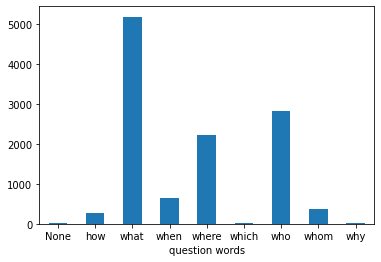

In [36]:
get_question_words_distribution(train_df)

question words
None       5
how       45
what     942
when     107
where    383
which      5
who      490
whom      61
why        3
Name: Meaningful, dtype: int64


0

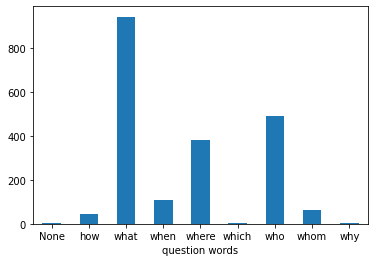

In [37]:
get_question_words_distribution(valid_df)

question words
None       20
how       141
what     2602
when      303
where    1144
which      20
who      1424
whom      168
why         8
Name: Meaningful, dtype: int64


0

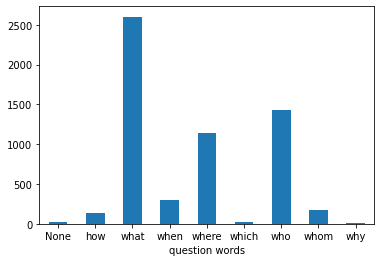

In [38]:
get_question_words_distribution(test_df)

In [58]:
def get_count_of_unique_words(dataframe):
    tokenizer = lambda string:string.strip().lower().split()
    tokenized_questions = dataframe['Question'].astype(str).apply(tokenizer).to_list()
    flatten_tokenized_questions = [item for sublist in tokenized_questions for item in sublist]
    return len(set(flatten_tokenized_questions))

In [61]:
print(get_count_of_unique_words(train_df))
print(get_count_of_unique_words(valid_df))
print(get_count_of_unique_words(test_df))

10791
3216
6796


In [71]:
def get_length(dataframe):
    tokenizer = lambda string:len(string.strip().lower().split())
    dataframe['length'] = dataframe['Question'].astype(str).apply(tokenizer)
    dataframe.hist(column=['length'], bins=50)
    return dataframe['length']
     

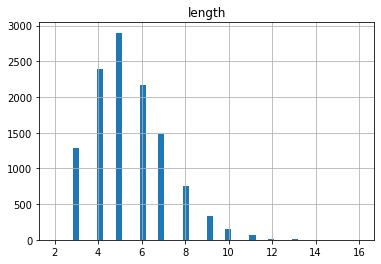

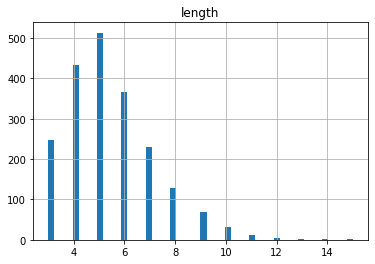

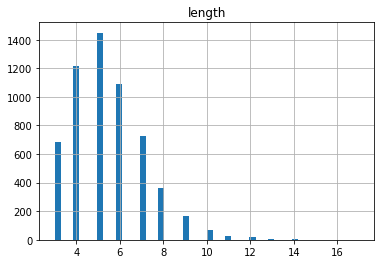

In [73]:
tr = get_length(train_df)
va = get_length(valid_df)
te = get_length(test_df)

In [79]:
train, valid, test = read_data()
train[1][1][2:]

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [113]:
def get_relation_component_count(dataset):
    results = []
    for item in dataset[1]:
#         print(item[2:])
        temp = ''.join(map(str, item[2:].tolist())).split('0')
        temp = list(filter(lambda item:item!='', temp))
        results.append(len(temp))
    components = []
    occurrences = []
    for item in set(results):
        components.append(str(item))
        occurrences.append(results.count(item))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(components,occurrences)
    plt.show() 
    return components,occurrences


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


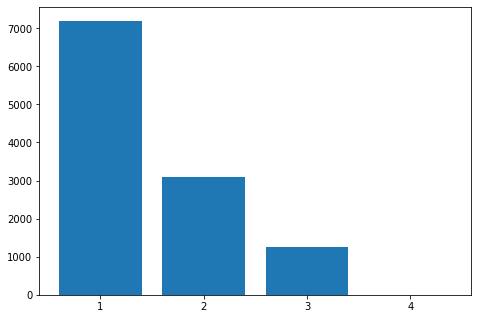

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


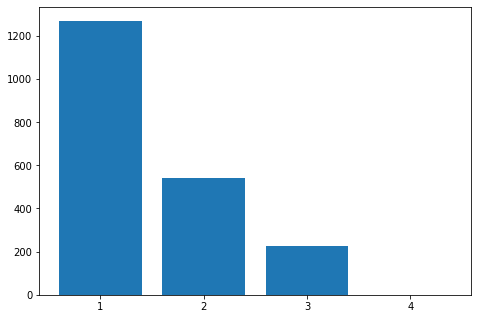

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


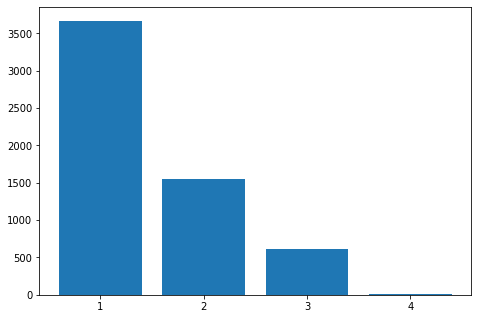

In [115]:
tr = get_relation_component_count(train)
va = get_relation_component_count(valid)
te = get_relation_component_count(test)

In [157]:
def get_relation_length(dataset):
    results = []
    for tok, rel in zip(dataset[0], dataset[1]):
        length = sum((tok!=0).astype(int))
        temp = sum(rel[2:])/length
        results.append(temp)
    results = map(lambda item:round(item, 1), results)
    results = list(results)
    components = []
    occurrences = []
    for item in sorted(set(results)):
        components.append(str(item))
        occurrences.append(results.count(item))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
#     ax.set_xticks(ax.get_xticks()[::2])
    ax.bar(components,occurrences)
    plt.show() 
    return components,occurrences

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


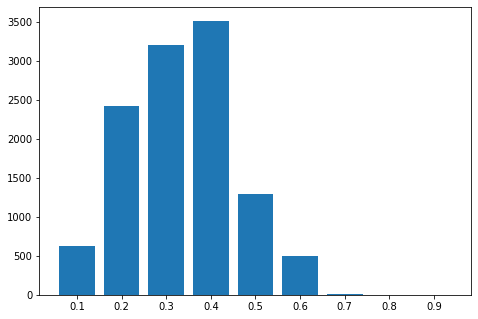

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


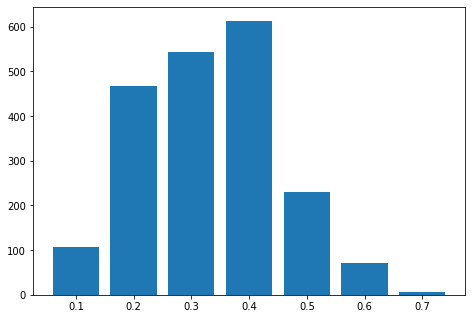

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


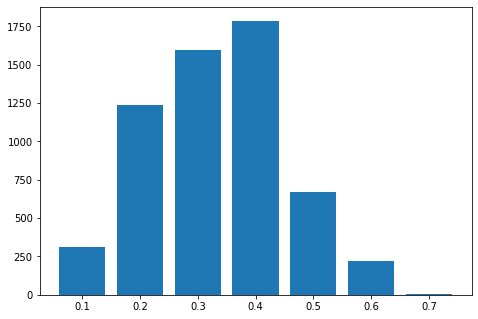

In [159]:
tr = get_relation_length(train); va = get_relation_length(valid); te = get_relation_length(test) 